In [2]:
import requests
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
gpcr_genes = pd.read_csv('../data/Ensembl_Grch37_gpcr_genome_locations.csv')['Ensembl id Grch37'].to_list()
non_gpcr_genes = pd.read_csv('../data/Homo_sapiens.GRCh37.85.uniprot.tsv',sep='\t')['gene_stable_id'].sample(n=1000).to_list()
non_gpcr_genes = [gene for gene in non_gpcr_genes if gene not in gpcr_genes]
genes = gpcr_genes + non_gpcr_genes
gene_classes = len(gpcr_genes) * ['gpcr'] + len(non_gpcr_genes) * ['non-gpcr']

server = 'http://grch37.rest.ensembl.org'
params={'type':'cds','multiple_sequences':'true'}
headers={ "Content-Type" : "application/json"} 

transcripts = []

for ensembl_gene, class_ in zip(genes, gene_classes):
    ext = f'/sequence/id/{ensembl_gene}'
    
    response = requests.get(server + ext, params=params, headers=headers)
    if response.status_code != 200:
        print(f'Bad request for {ensembl_gene}')
        continue
    else:
        gene_transcripts = pd.DataFrame(response.json())
        gene_transcripts['cds_length'] = gene_transcripts.seq.str.len()
        gene_transcripts = gene_transcripts.drop(columns='seq')
        gene_transcripts['class'] = class_
    transcripts.append(gene_transcripts)

transcripts = pd.concat(transcripts)
transcripts.to_csv('../data/transcript_lengths.csv')

In [3]:
transcripts = pd.read_csv('../data/transcript_lengths.csv',index_col=0)
df_canonical_Grch38 = pd.read_csv('../data/Homo_sapiens.GRCh38.104.canonical.tsv',sep='\t',header=None)
df_canonical_Grch38.columns = ['gene_versioned','transcript_versioned','type']
df_canonical_Grch38[['gene','gene_version']] = df_canonical_Grch38.gene_versioned.str.split('.',n=1,expand=True)
df_canonical_Grch38[['transcript','transcript_version']] = df_canonical_Grch38.transcript_versioned.str.split('.',n=1,expand=True)
df_canonical_Grch38 = df_canonical_Grch38.drop(columns=['gene_versioned','transcript_versioned'])
df_canonical_Grch38 = df_canonical_Grch38[df_canonical_Grch38['type']=='Ensembl Canonical']
transcript_lengths_w_canonical = df_canonical_Grch38.merge(transcripts,left_on='transcript',right_on='id',how='right')
transcript_lengths_w_canonical['canonical'] = ~transcript_lengths_w_canonical.type.isna()
transcript_lengths_w_canonical = transcript_lengths_w_canonical.drop(columns=['type','gene','gene_version','transcript','transcript_version'])
transcript_lengths_w_canonical

,id,molecule,desc,version,query,cds_length,class,canonical
0,ENST00000368122,dna,NaN,2,ENSG00000213088,1011,gpcr,True
1,ENST00000435307,dna,NaN,1,ENSG00000213088,465,gpcr,False
2,ENST00000537147,dna,NaN,1,ENSG00000213088,1011,gpcr,False
3,ENST00000368121,dna,NaN,2,ENSG00000213088,1017,gpcr,False
4,ENST00000442925,dna,NaN,1,ENSG00000144648,1155,gpcr,False
...,...,...,...,...,...,...,...,...
11630,ENST00000454006,dna,NaN,2,ENSG00000237710,777,non-gpcr,True
11631,ENST00000411424,dna,NaN,2,ENSG00000237710,687,non-gpcr,False
11632,ENST00000456386,dna,NaN,1,ENSG00000237710,688,non-gpcr,False
11633,ENST00000458614,dna,NaN,1,ENSG00000237710,708,non-gpcr,False


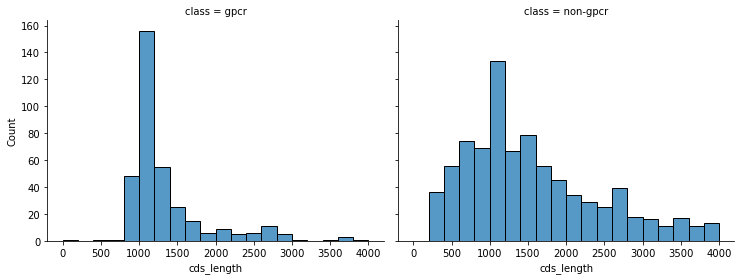

In [11]:
transcript_lengths_canonical = transcript_lengths_w_canonical[transcript_lengths_w_canonical.canonical]
sns.displot(transcript_lengths_canonical,x='cds_length',col='class',kind='hist',binrange=(0,4000),bins=20,aspect=1.3,height=4)
plt.savefig('../plots/canonical_CDS_length_by_gene.png',dpi=700)

In [7]:
transcript_lengths_canonical.groupby('class').agg({'cds_length':[np.mean,np.median]})

cds_length        
                 mean  median
class                        
gpcr      1525.204986  1155.0
non-gpcr  1844.089165  1419.0